In [0]:
![ -e images.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=18y17PXpo_Qwt2l_FF_7ODJYcQYEExOeF' -O images.tar.bz2
![ -d images ] || tar jxf images.tar.bz2

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
!pip install -q gdown httpimport

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
import torch

import collections
import os
import re

import numpy as np
import scipy.io
import scipy.ndimage


import logging
logging.getLogger("PIL").setLevel(logging.INFO)

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

import httpimport
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
    import common.plotting

In [0]:
CUDA = True

def to_np(x):
    return x.detach().cpu().numpy()

def to_tensor(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return torch.tensor(x, **kwargs)

In [0]:
!pip uninstall -y Pillow


Uninstalling Pillow-5.4.1:
  Successfully uninstalled Pillow-5.4.1


In [0]:
!pip install Pillow==5.3.0


    100% |████████████████████████████████| 2.0MB 13.1MB/s 


In [0]:
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime

5.3.0


In [0]:
#
# TODO: fill in the blanks in the VGG network. The function multi_layer_activations
# is only needed for the last homework.
#



class VGGPreprocess(torch.nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """
    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]
    
    def forward(self, x):
        """Normalize a single image or a batch of images
        
        Args:
            x: a pytorch Variable containing and float32 RGB image tensor with 
              dimensions (batch_size x width x heigth x RGB_channels) or 
              (width x heigth x RGB_channels).
        Returns:
            a torch Variable containing a normalized BGR image with shape 
              (batch_size x BGR_channels x width x heigth)
        """
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        # x is batch * width * heigth *channels,  
        # make it batch * channels * width * heigth 
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2)
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        x = (x - Variable(means)) / Variable(stds)
        return x

In [0]:
class VGG(torch.nn.Module):
    """Wrapper around a VGG network allowing convenient extraction of layer activations.
    
    """
    FEATURE_LAYER_NAMES = {
        'vgg16':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1"
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2"
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "pool3"
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3",
             "relu4_3", "pool4"
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3",
             "relu5_3", "pool5"],
        'vgg19':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "conv3_4", "relu3_4", "pool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2",
             "conv4_3", "relu4_3", "conv4_4", "relu4_4", "pool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2",
             "conv5_3", "relu5_3", "conv5_4", "relu5_4", "pool5"]}
    
    def __init__(self, model='vgg19'):
        super(VGG, self).__init__()
        all_models = {'vgg16': torchvision.models.vgg16,
                      'vgg19': torchvision.models.vgg19}   
        vgg = all_models[model](pretrained=True)
        
        self.preprocess = VGGPreprocess()
        self.features = vgg.features
        self.classifier = vgg.classifier
        self.softmax = torch.nn.Softmax(dim=-1)
        
        self.feature_names = self.FEATURE_LAYER_NAMES[model]
        
        assert len(self.feature_names) == len(self.features)

    def forward(self, x):
        """ Return pre-softmax unnormalized logits. 
        """
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def probabilities(self, x):
        """Return class probabilities.
        """
        logits = self(x)
        return self.softmax(logits)[0]
        
    def layer_activations(self, x, layer_name):
        """Return activations of a selected layer.
        """
        x = self.preprocess(x)
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name == layer_name:
                return x
        raise ValueError('Layer %s not found' % layer_name)
    
    def multi_layer_activations(self, x, layer_names):
        """Return activations of all requested layers.
        """
        # TODO: implement me!
        res = []
        x = self.preprocess(x)
        activations_by_names = {}
    
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name in layer_names:
                activations_by_names[name] = x
        
        for name in layer_names:
            if name not in activations_by_names.keys():
                raise ValueError('Layer %s not found' % name)
            res.append(activations_by_names[name])
        return res

    def predict(self, x):
        """Return predicted class IDs.
        """
        logits = self(x)
        pred = logits.max(dim=1)[1]
        return pred
    
    def top_predicts(self, x, k = 5):
        logits = self(x)
        preds = logits.topk(k, dim=1)[1]
        return preds
    
vgg = VGG('vgg19')

if CUDA:
    vgg.cuda()

In [0]:
!ls images

arab_text.jpg	   hoovertowernight.jpg      starry_night_google.jpg
brad_pitt.jpg	   picasso_selfport1907.jpg  starry_night.jpg
crowd.jpg	   pl_text.jpg		     the_scream.jpg
escher_sphere.jpg  seated-nude.jpg	     tubingen.jpg
frida_kahlo.jpg    shipwreck.jpg	     woman-with-hat-matisse.jpg
golden_gate.jpg    starry_night_crop.png     wood.jpeg


In [0]:
from PIL import Image


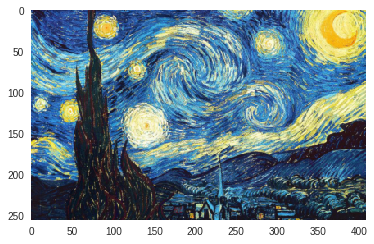

In [0]:

def load_image(path, size=256):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        img = torchvision.transforms.Scale(size)(img)
        return numpy.asarray(img).astype('float32') / 255.0

imshow(load_image('images/starry_night.jpg'))
grid(False)

In [0]:
class StyleTransferNet(object):
    def __init__(self, style_layers, content_layers, vgg_model='vgg19',
                 content_weight=5e0, style_weight=1e2):
        self.style_layers = style_layers
        self.style_captures = []
        self.style_weight = style_weight
        self.content_layers = content_layers
        self.content_captures = []
        self.content_weight = content_weight
        self.vgg = VGG(vgg_model)
        self.vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.mse = nn.MSELoss()
        self.mse_false = nn.MSELoss(size_average=False)
        
    def capture_content(self, x):
        # TODO
        # implement saving naural activations for a chosen set of content layers
        self.content_captures = self.vgg.multi_layer_activations(x, self.content_layers)
    
    def capture_style(self, x):
        style_layers = self.vgg.multi_layer_activations(
            x, self.style_layers)
        self.style_captures = [self._gram_mat(l) for l in style_layers]

    def get_loss(self, x):
        needed_layers = self.content_layers + self.style_layers
        needed_values = self.vgg.multi_layer_activations(
            x, needed_layers)
        content_values = needed_values[:len(self.content_layers)]
        style_values = needed_values[len(self.content_layers):]
        
        self.content_losses = []
        self.style_losses = []
        
        for gen_img,org_img in zip(content_values, self.content_captures):
            self.content_losses.append(self.mse(gen_img, org_img))
        

        style_values = [self._gram_mat(l) for l in style_values]  
        for gen_img,org_img in zip(style_values, self.style_captures):
            self.style_losses.append(self.mse(gen_img, org_img))
                
        # TODO:
        # append onto the lists  self.content_losses and self.style_losses 
        # the L2 (euclidean) distances between the captured statistics and the 
        # reconstructed image's ones. Remember about applying the gram matrix to style!
        # You can use the self.mse to compute the L2 distance
        
        loss = sum(self.content_losses) * self.content_weight
        loss += sum(self.style_losses) * self.style_weight
        
        return loss
            
    def _gram_mat(self, x):
        """
        Compute the matrix of feature correlations.
        
        Input:
            x: tensor of size batch_size x num_channels x width x heigth
        
        Output:
            tensor of size batch_size x num_chanels x num_channels given by the formula
            
            out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        """
        # TODO
        # Compute the Gram matrix, as defined in the docstring. Try to implement it as efficiently as possible.
        # Gram matrix for the features in relu1_1 of the output image.
        b, c, w, h = x.size()                 
        features = x.view(b * c, w * h)       
        G = torch.mm(features, features.t())   
        
        return G.div(b * c * w * h)           

In [0]:
# TODO find a giid set of layers for the content and style images.
model = StyleTransferNet(
    style_layers=['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'],
    content_layers=['conv4_2'], content_weight=10e0, style_weight=1e6)

if CUDA:
    model.vgg.cuda()

In [0]:
style_img_path = 'images/starry_night.jpg'
content_img_path = 'images/golden_gate.jpg'

style_img_size = 256
content_img_size = 256

style_image = load_image(style_img_path, style_img_size)
content_image = load_image(content_img_path, content_img_size)
content_shape = content_image.shape

print 'Capturing content'
model.capture_content(to_tensor(content_image))

print 'Capturing style'
model.capture_style(to_tensor(style_image))

Capturing content
Capturing style


In [0]:
# image = load_image(content_img_path, 512)
image = np.random.randn(*content_shape).astype(np.float32) * 0.01 + 0.5
image = to_tensor(image, requires_grad=True)

# try using Adam or LBFGS

#optimizer = torch.optim.Adam([image], lr=0.001)  #, momentum=0.5)
optimizer = torch.optim.LBFGS([image])

Iteration     22 | loss 28.3485584


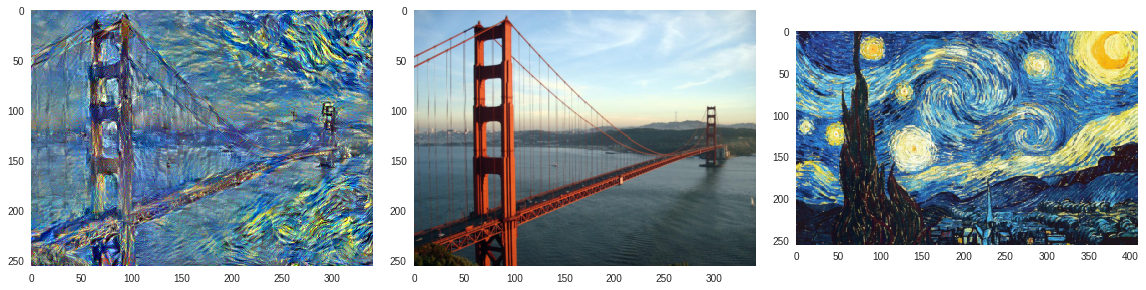

In [0]:
from IPython import display

# Training loop
max_iters = 200
check_every = 5
old_loss = np.inf
loss_type = 'adam'
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    grid(False)
    fig.add_subplot(133).imshow(style_image)
    grid(False)
    ax = fig.add_subplot(131)
    
    tight_layout()
    imsh = ax.imshow(to_np(image))
    grid(False)
    for iter_ in range(max_iters):
        
        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            # print('loss:', loss.data.cpu().numpy()[0])
            loss.backward()
            return loss
        
        if loss_type == 'adam':
            #loss = model.get_loss(image)
            #loss.backward()
            loss = optimizer.step(closure)
            image.grad.data.zero_()
        elif loss_type == 'lbfgs':
            loss = optimizer.step(closure)
        else:
            raise ValueError
        #image.data = image.data.clip(0, 1)
            
        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            #ax.imshow(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)
            
            
            print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item())
            for i, l in enumerate(model.content_losses):
                print '  Content loss {}: {: >8.4f}'.format(i + 1, l.item() * model.content_weight)
            for i, l in enumerate(model.style_losses):
                print '  Style loss {}: {: >10.4f}'.format(i + 1, l.item() * model.style_weight)
            
        old_loss = loss.data[0]
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item())

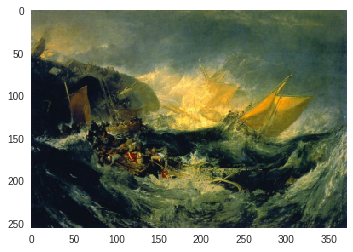

In [0]:
def load_image(path, size=256):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        img = torchvision.transforms.Scale(size)(img)
        return numpy.asarray(img).astype('float32') / 255.0

imshow(load_image('images/shipwreck.jpg'))


grid(False)

In [0]:
style_img_path2 =  'images/shipwreck.jpg'
content_img_path2 = 'images/golden_gate.jpg'

style_img_size = 256
content_img_size = 256

style_image2 = load_image(style_img_path2, style_img_size)
content_image2 = load_image(content_img_path2, content_img_size)
content_shape2 = content_image.shape

print 'Capturing content'
model.capture_content(to_tensor(content_image2))

print 'Capturing style'
model.capture_style(to_tensor(style_image2))

Capturing content
Capturing style


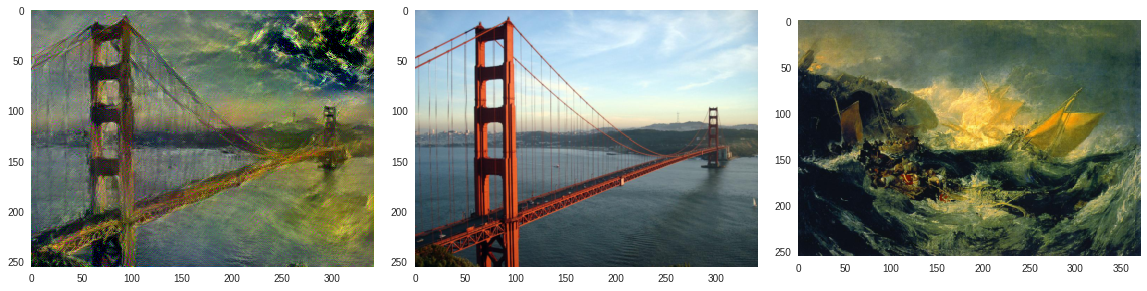

Iteration    240 | loss 19.4269638
  Content loss 1:  10.6172
  Style loss 1:     0.1796
  Style loss 2:     0.1956
  Style loss 3:     0.7826
  Style loss 4:     7.6508


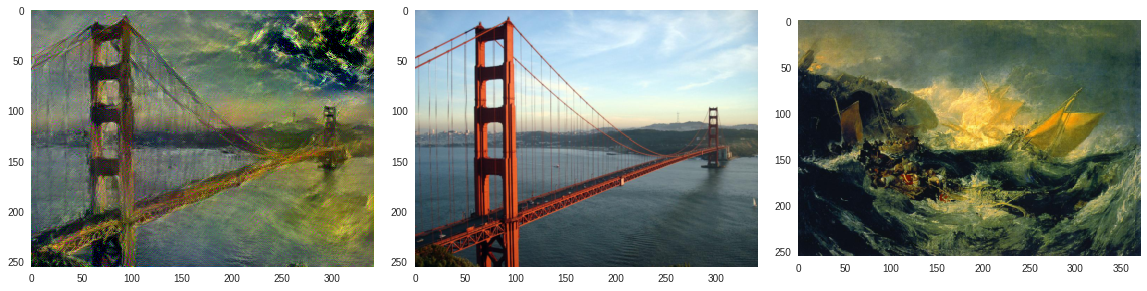

In [0]:
from IPython import display

# Training loop
max_iters = 250
check_every = 10
old_loss = np.inf
loss_type = 'adam'
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image2)
    grid(False)
    fig.add_subplot(133).imshow(style_image2)
    grid(False)
    ax = fig.add_subplot(131)
    
    tight_layout()
    imsh = ax.imshow(to_np(image))
    grid(False)
    for iter_ in range(max_iters):
        
        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            #print('loss:', loss.data.cpu().numpy()[0])
            loss.backward()
            return loss
        
        if loss_type == 'adam':
            #loss = model.get_loss(image)
            #loss.backward()
            loss = optimizer.step(closure)
            image.grad.data.zero_()
        elif loss_type == 'lbfgs':
            loss = optimizer.step(closure)
        else:
            raise ValueError
        #image.data = image.data.clip(0, 1)
            
        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            #ax.imshow(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)
            
            
            print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item())
            for i, l in enumerate(model.content_losses):
                print '  Content loss {}: {: >8.4f}'.format(i + 1, l.item() * model.content_weight)
            for i, l in enumerate(model.style_losses):
                print '  Style loss {}: {: >10.4f}'.format(i + 1, l.item() * model.style_weight)
            
        old_loss = loss.data[0]
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.item())